In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import time
import numpy as np
import datetime

In [2]:
data=pd.read_csv('sentiment_full.csv')
#df['Date']=pd.to_datetime(['Date'],format="[datetime.date(%Y,%m,%d)]")
#print(df['Date'][1])
i = data['Date'].astype(str)\
      .str.findall('\d+')\
      .str.join('/')
data['Date'] = pd.to_datetime(i, errors='coerce')
data['Date'][1]

Timestamp('2018-02-27 00:00:00')

In [3]:
# get market info for bitcoin from the start of 2016 to the current day
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# when Volume is equal to '-' convert it to 0
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# look at the first few rows
bitcoin_market_info=bitcoin_market_info[['Date','Close','Open','High','Low','Volume','Market Cap']]
#bitcoin_market_info.rename(columns={"Date":"Time"},inplace=True)
bitcoin_market_info.head()

,Date,Close,Open,High,Low,Volume,Market Cap
0,2018-03-08,9395.01,9951.44,10147.4,9335.87,7186090000,168241000000
1,2018-03-07,9965.57,10803.90,10929.5,9692.12,8797910000,182631000000
2,2018-03-06,10779.90,11500.10,11500.1,10694.30,6832170000,194378000000
3,2018-03-05,11573.30,11532.40,11704.1,11443.90,6468540000,194903000000
4,2018-03-04,11512.60,11497.40,11512.6,11136.10,6084150000,194289000000


In [4]:
merged_data=bitcoin_market_info.merge(data,on='Date',how='inner')
#merged_data.drop(['Unnamed: 0'],inplace=True,axis=1)
#merged_data.to_csv('merged_price_sentiment.csv')
merged_data[:8]

,Date,Close,Open,High,Low,Volume,Market Cap,Sentiment
0,2018-02-28,10397.90,10687.20,11089.80,10393.10,6936190000,180510000000,0.070307
1,2018-02-27,10725.60,10393.90,10878.50,10246.10,6966180000,175536000000,0.059455
2,2018-02-26,10366.70,9669.43,10475.00,9501.73,7287690000,163283000000,0.059455
3,2018-02-25,9664.73,9796.42,9923.22,9407.06,5706940000,165407000000,0.059455
4,2018-02-24,9813.07,10287.70,10597.20,9546.97,6917930000,173682000000,0.059455
5,2018-02-23,10301.10,9937.07,10487.30,9734.56,7739500000,167746000000,0.059455
6,2018-02-22,10005.00,10660.40,11039.10,9939.09,8040080000,179936000000,0.059455
7,2018-02-21,10690.40,11372.20,11418.50,10479.10,9405340000,191927000000,0.110849


In [5]:
from keras.models import load_model
model1 = load_model('close_price_lstm.h5')
model2=load_model('sentiment_price.h5')

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
predict_data=np.array([[10725.60,10393.90,10878.50,10246.10,6966180000,175536000000],
                      [10366.70,9669.43,10475.00,9501.73,7287690000,163283000000],
                      [9664.73,9796.42,9923.22,9407.06,5706940000,165407000000],
                      [9813.07,10287.70,10597.20,9546.97,6917930000,173682000000],
                      [10301.10,9937.07,10487.30,9734.56,7739500000,167746000000],
                      [10005.00,10660.40,11039.10,9939.09,8040080000,179936000000]])
scaler = MinMaxScaler(feature_range=(0, 1))
a=scaler.fit_transform(predict_data)
pre=model1.predict(a.reshape(predict_data.shape[0],1,6))
phat=np.concatenate((pre,a[:,1:]),axis=1)
#print(phat)
predicted=scaler.inverse_transform(phat)
#print(predicted)

In [7]:
real_close=[10397.90,10725.60,10366.70,9664.73,9813.07,10301.10]
predicted_close=[]
date=[]
difference=[]
pr_change=[]
date=pd.date_range('02-23-2018','02-28-2018',freq='D').sort_values(ascending=False)
#print(date)
for i in range(predict_data.shape[0]):
    predicted_close.append(predicted[i,0])
    difference.append(abs(predicted[i,0]-real_close[i]))
    pr_change.append((abs(predicted[i,0]-real_close[i])/predicted[i,0])*100)
df=pd.DataFrame({'Date':date})
df['real_close']=real_close
df['predicted_close']=predicted_close
df['Difference']=difference
df['Percentage_change']=pr_change
print(df)

        Date  real_close  predicted_close  Difference  Percentage_change
0 2018-02-28    10397.90     10491.695183   93.795183           0.893995
1 2018-02-27    10725.60      9997.942656  727.657344           7.278071
2 2018-02-26    10366.70      9703.386253  663.313747           6.835900
3 2018-02-25     9664.73     10050.264651  385.534651           3.836065
4 2018-02-24     9813.07     10110.501936  297.431936           2.941812
5 2018-02-23    10301.10     10349.661903   48.561903           0.469212


In [8]:
data_sentiment=np.array([[ 10725.60,0.059455],
                         [10366.70,0.059455],
                         [9664.73,0.059455],
                         [9813.07,0.059455],
                         [10301.10,0.059455],
                         [10005.00,0.059455]])
scaler1 = MinMaxScaler(feature_range=(0, 1))
b=scaler1.fit_transform(data_sentiment)
pred=model2.predict(data_sentiment.reshape(data_sentiment.shape[0],1,data_sentiment.shape[1]))
#print(pred)
pred=np.concatenate((pred,data_sentiment[:,1:]),axis=1)
#print(pred)
#print(data_sentiment[:,1:])
pred = scaler1.inverse_transform(pred)
pred=pred/2

In [9]:
real_close=[10397.90,10725.60,10366.70,9664.73,9813.07,10301.10]
predicted_close=[]
date=[]
difference=[]
pr_change=[]
date=pd.date_range('02-23-2018','02-28-2018',freq='D').sort_values(ascending=False)
for i in range(predict_data.shape[0]):
    predicted_close.append(pred[i,0])
    difference.append(abs(pred[i,0]-real_close[i]))
    pr_change.append((abs(pred[i,0]-real_close[i])/pred[i,0])*100)
df1=pd.DataFrame({'Date':date})
df1['real_close']=real_close
df1['predicted_close']=predicted_close
df1['Difference']=difference
df1['Percentage_change']=pr_change
print(df1)

        Date  real_close  predicted_close   Difference  Percentage_change
0 2018-02-28    10397.90      5760.505096  4637.394904          80.503269
1 2018-02-27    10725.60      5760.505096  4965.094904          86.192006
2 2018-02-26    10366.70      5760.505096  4606.194904          79.961650
3 2018-02-25     9664.73      5760.505096  3904.224904          67.775739
4 2018-02-24     9813.07      5760.505096  4052.564904          70.350860
5 2018-02-23    10301.10      5760.505096  4540.594904          78.822861


In [10]:
prediction_merged=df1.merge(df,on='Date',how='outer')
prediction_merged.rename(columns={'predicted_close_x':'Sentiment_prediction',
                                  'predicted_close_y':'Simple_lstm_prediction',
                                 'real_close_x':'Real close'},inplace=True)
prediction_merged.drop(['Difference_x','Percentage_change_x','real_close_y','Difference_y','Percentage_change_y'],inplace=True,axis=1)
print(prediction_merged)

        Date  Real close  Sentiment_prediction  Simple_lstm_prediction
0 2018-02-28    10397.90           5760.505096            10491.695183
1 2018-02-27    10725.60           5760.505096             9997.942656
2 2018-02-26    10366.70           5760.505096             9703.386253
3 2018-02-25     9664.73           5760.505096            10050.264651
4 2018-02-24     9813.07           5760.505096            10110.501936
5 2018-02-23    10301.10           5760.505096            10349.661903


In [11]:
dataframe=pd.read_csv('merged_price_sentiment.csv')
dataframe.drop("Unnamed: 0",axis=1,inplace=True)
dataframe[:8]

,Date,Close,Open,High,Low,Volume,Market Cap,Sentiment
0,2018-02-28,10397.90,10687.20,11089.80,10393.10,6936190000,180510000000,0.070307
1,2018-02-27,10725.60,10393.90,10878.50,10246.10,6966180000,175536000000,0.059455
2,2018-02-26,10366.70,9669.43,10475.00,9501.73,7287690000,163283000000,0.059455
3,2018-02-25,9664.73,9796.42,9923.22,9407.06,5706940000,165407000000,0.059455
4,2018-02-24,9813.07,10287.70,10597.20,9546.97,6917930000,173682000000,0.059455
5,2018-02-23,10301.10,9937.07,10487.30,9734.56,7739500000,167746000000,0.059455
6,2018-02-22,10005.00,10660.40,11039.10,9939.09,8040080000,179936000000,0.059455
7,2018-02-21,10690.40,11372.20,11418.50,10479.10,9405340000,191927000000,0.110849


In [12]:
dataframe.drop(['Date'],inplace=True,axis=1)
print(dataframe.head())
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataframe)

      Close      Open      High       Low      Volume    Market Cap  Sentiment
0  10397.90  10687.20  11089.80  10393.10  6936190000  180510000000   0.070307
1  10725.60  10393.90  10878.50  10246.10  6966180000  175536000000   0.059455
2  10366.70   9669.43  10475.00   9501.73  7287690000  163283000000   0.059455
3   9664.73   9796.42   9923.22   9407.06  5706940000  165407000000   0.059455
4   9813.07  10287.70  10597.20   9546.97  6917930000  173682000000   0.059455


In [13]:
columns=dataframe.columns
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(-i))
		names += [(j) for j in columns]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(i))
		if i == 0:
			names += [("output "+j) for j in columns]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [14]:
reframed = series_to_supervised(scaled, 1, 1)
print(dataframe.shape)
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

(748, 7)
      Close      Open      High       Low    Volume  Market Cap  Sentiment  \
0  0.541059  0.524411  0.532558  0.530614  0.291347    0.529903   0.178618   
1  0.522282  0.486473  0.512080  0.490582  0.304849    0.491656   0.178618   
2  0.485554  0.493123  0.484077  0.485491  0.238465    0.498286   0.178618   
3  0.493316  0.518850  0.518282  0.493015  0.289321    0.524116   0.178618   
4  0.518849  0.500488  0.512704  0.503104  0.323822    0.505587   0.178618   

   output Close  
0      0.523914  
1      0.541059  
2      0.522282  
3      0.485554  
4      0.493316  


In [15]:
values=reframed.values
train = values[9:550, :]
test = values[550:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(541, 1, 7) (541,) (197, 1, 7) (197,)


Train on 541 samples, validate on 197 samples
Epoch 1/50
 - 1s - loss: 0.1694 - val_loss: 0.0481
Epoch 2/50
 - 0s - loss: 0.1281 - val_loss: 0.0513
Epoch 3/50
 - 0s - loss: 0.0996 - val_loss: 0.0448
Epoch 4/50
 - 0s - loss: 0.0689 - val_loss: 0.0269
Epoch 5/50
 - 0s - loss: 0.0375 - val_loss: 0.0052
Epoch 6/50
 - 0s - loss: 0.0196 - val_loss: 0.0100
Epoch 7/50
 - 0s - loss: 0.0194 - val_loss: 0.0060
Epoch 8/50
 - 0s - loss: 0.0154 - val_loss: 0.0024
Epoch 9/50
 - 0s - loss: 0.0154 - val_loss: 0.0021
Epoch 10/50
 - 0s - loss: 0.0153 - val_loss: 0.0018
Epoch 11/50
 - 0s - loss: 0.0148 - val_loss: 0.0016
Epoch 12/50
 - 0s - loss: 0.0153 - val_loss: 0.0030
Epoch 13/50
 - 0s - loss: 0.0143 - val_loss: 0.0021
Epoch 14/50
 - 0s - loss: 0.0126 - val_loss: 0.0016
Epoch 15/50
 - 0s - loss: 0.0121 - val_loss: 0.0014
Epoch 16/50
 - 0s - loss: 0.0119 - val_loss: 0.0017
Epoch 17/50
 - 0s - loss: 0.0117 - val_loss: 0.0016
Epoch 18/50
 - 0s - loss: 0.0139 - val_loss: 0.0046
Epoch 19/50
 - 0s - loss: 0

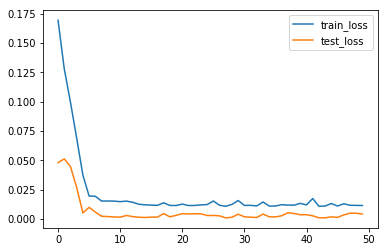

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation, Dense
# design network
model = Sequential()
model.add(LSTM(80, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train_loss')
pyplot.plot(history.history['val_loss'], label='test_loss')
pyplot.legend()
pyplot.show()

In [17]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse =sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 87.632


In [18]:
predict_data=np.array([[10725.60,10393.90,10878.50,10246.10,6966180000,175536000000,0.059455],
                      [10366.70,9669.43,10475.00,9501.73,7287690000,163283000000,0.059455],
                      [9664.73,9796.42,9923.22,9407.06,5706940000,165407000000,0.059455],
                      [9813.07,10287.70,10597.20,9546.97,6917930000,173682000000,0.059455],
                      [10301.10,9937.07,10487.30,9734.56,7739500000,167746000000,0.059455],
                      [10005.00,10660.40,11039.10,9939.09,8040080000,179936000000,0.059455]])
#print(predict_data.shape)
c=scaler.fit_transform(predict_data)
pre=model.predict(c.reshape(predict_data.shape[0],1,predict_data.shape[1]))
phat=np.concatenate((pre,c[:,1:]),axis=1)
#print(phat)
predicted=scaler.inverse_transform(phat)
#print(predicted)

In [21]:
real_close=[10397.90,10725.60,10366.70,9664.73,9813.07,10301.10]
predicted_close=[]
date=[]
difference=[]
pr_change=[]
date=pd.date_range('2-23-2018','2-28-2018',freq='D').sort_values(ascending=False)
#print(date)
for i in range(predicted.shape[0]):
    predicted_close.append(predicted[i,0])
    difference.append(abs(predicted[i,0]-real_close[i]))
    pr_change.append((abs(predicted[i,0]-real_close[i])/predicted[i,0])*100)
#print(date)
df2=pd.DataFrame({'Date':date})
#print(len(df2))
df2['Real_close']=real_close
df2['Predicted_close']=predicted_close
#df2['Difference']=difference
#df2['Percentage_change']=pr_change
print(df2)

        Date  Real_close  Predicted_close
0 2018-02-28    10397.90     10558.581995
1 2018-02-27    10725.60      9995.170405
2 2018-02-26    10366.70      9713.967160
3 2018-02-25     9664.73     10080.968339
4 2018-02-24     9813.07     10136.406161
5 2018-02-23    10301.10     10413.636403


In [22]:
combined=df.merge(df2,on='Date',how='inner')
combined.rename(columns={'real_close':'Real Close','predicted_close':'Model_numeric_data',
                        'Predicted_close':'Model_numeric _data+Sentiments'},inplace=True)
combined.drop(['Real_close','Difference','Percentage_change'],inplace=True,axis=1)
print(combined)

        Date  Real Close  Model_numeric_data  Model_numeric _data+Sentiments
0 2018-02-28    10397.90        10491.695183                    10558.581995
1 2018-02-27    10725.60         9997.942656                     9995.170405
2 2018-02-26    10366.70         9703.386253                     9713.967160
3 2018-02-25     9664.73        10050.264651                    10080.968339
4 2018-02-24     9813.07        10110.501936                    10136.406161
5 2018-02-23    10301.10        10349.661903                    10413.636403
